<a href="https://colab.research.google.com/github/ShaliniR8/lahman-mlb/blob/main/combined_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [102]:
from sklearn import preprocessing
from sklearn import compose
from sklearn import impute
from sklearn import decomposition
from sklearn import model_selection
from sklearn import tree
from sklearn.utils import compute_class_weight
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn import pipeline

In [3]:
%%capture
!pip install xgboost

In [4]:
#@title Load Dataset

%%capture
# ---- filtered (only from 1910) 
# !wget https://github.com/ShaliniR8/lahman-mlb/raw/main/baseballdatabase.zip
# !unzip /content/baseballdatabase.zip -d "/content/"


#---- full
!wget https://github.com/ShaliniR8/lahman-mlb/raw/main/baseballdatabank_2022.zip
!unzip /content/baseballdatabank_2022.zip -d "/content/"

path = "/content/baseballdatabank-2022.2/core/"



In [118]:
batting = pd.read_csv(path + "Batting.csv")
pitching = pd.read_csv(path + "Pitching.csv")
people = pd.read_csv(path + "People.csv")
# fielding = pd.read_csv(path + "Fielding.csv")
teams = pd.read_csv(path + "Teams.csv")

## Dataset

In [188]:
batting = batting[["playerID","yearID","teamID", "H", "BB", "HBP", "AB", "SF", "2B", "3B", "HR"]].copy()
pitching = pitching[["playerID","yearID","teamID", "ERA"]].copy()
people = people[['playerID', 'birthYear']].copy()
teams = teams[['teamID', 'yearID', 'W', 'L']].copy()
all_dfs = { 
    'batting': batting,
    'pitching': pitching,
    'people':people,
    # 'fielding':fielding,
    'teams':teams
}

## Cleaning

In [189]:

def cleanX(X):
  categorical_features = X.select_dtypes("object").columns.to_list()
  numerical_features = X.select_dtypes(["int64", "float64"]).columns.to_list()
  knnImp = impute.KNNImputer(missing_values=np.nan)
  simpleImp = impute.SimpleImputer(strategy = 'median', missing_values=np.nan)
  Ximputer = compose.ColumnTransformer([
    ('categorical', knnImp, categorical_features),
    ('numerical', simpleImp, numerical_features)
  ])
  X_ = Ximputer.fit_transform(X)

  return X_

In [190]:
for name,df in all_dfs.items():
  not_keys = list(set(df.columns.to_list()) - {'teamID', 'playerID'})
  keys = list(set(df.columns.to_list()) - set(not_keys))
  imputedX = pd.DataFrame(cleanX(df[not_keys]), columns = not_keys, dtype='int64')
  all_dfs[name] = pd.concat([df[keys], imputedX], axis = 1)
  print(name)
  print(all_dfs[name].info())
  


batting
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110495 entries, 0 to 110494
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   playerID  110495 non-null  object
 1   teamID    110495 non-null  object
 2   BB        110495 non-null  int64 
 3   HR        110495 non-null  int64 
 4   H         110495 non-null  int64 
 5   AB        110495 non-null  int64 
 6   3B        110495 non-null  int64 
 7   HBP       110495 non-null  int64 
 8   2B        110495 non-null  int64 
 9   yearID    110495 non-null  int64 
 10  SF        110495 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 9.3+ MB
None
pitching
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49430 entries, 0 to 49429
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   playerID  49430 non-null  object
 1   teamID    49430 non-null  object
 2   yearID    49430 non-null  int64 
 3   ERA    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version, passing float-dtype values and an integer dtype to DataFrame will retain floating dtype if they cannot be cast losslessly (matching Series behavior). To retain the old behavior, use DataFrame(data).astype(dtype)
  after removing the cwd from sys.path.


## Constructing Features

No need to run this after the feature is already constructed 

In [ ]:
def win_perc(team, year):
    team_year = teams[(teams['yearID'] == year) & (teams['teamID'] == team)]
    if team_year.empty:
        return np.nan
    team_year = team_year.iloc[0]
    w = team_year['W']
    l = team_year['L']
    return w / (w + l)


def get_rolling_win_perc (row):
    year = row['yearID']
    team = row['teamID']
    year1 = win_perc(team, year - 1)
    year2 = win_perc(team, year - 2)
    year3 = win_perc(team, year - 3)
    year4 = win_perc(team, year - 4)
    year5 = win_perc(team, year - 5)
    if (year1 == np.nan or year2 == np.nan or year3 == np.nan or year3 == np.nan or year4 == np.nan or year5 == np.nan):
      if (year1 == np.nan or year2 == np.nan or year3 ==np.nan):
        if year1 == np.nan: 
          return (year, team, np.nan, np.nan, np.nan)
        else:
          return (year, team, year1, np.nan, np.nan)
      else:
        return (year, team, year1, (year1 + year2 + year3)/3, np.nan )
    else: 
        return (year, team, year1, (year1 + year2 + year3)/3, (year1 + year2 + year3 + year4 + year5)/5)


In [ ]:

def get_age(row):
  playerID = row['playerID']
  yearID = row['yearID']
  birthYear = people[people['playerID'] == playerID]['birthYear']
  birthYear = birthYear.iloc[0]
  age = yearID - birthYear
  row['age'] = age
  return row

In [ ]:
def ops_calc(row):
  #calc done on rows of batting table
  if row['AB'] == 0:
      return np.nan
  HBP = row["HBP"]
  SF = row["SF"]
  singles = row["H"] - row["2B"] - row["3B"] - row["HR"]
  obp = (row["H"] + row["BB"] + HBP) / (row["AB"] + row["BB"] + SF + HBP)
  slug = (singles + (2 * row["2B"]) + (3 * row["3B"]) + (4 * row["HR"])) / row["AB"]
 
  return slug + obp 

def get_ops(row):
  year = row['yearID'] - 1
  team = row['teamID']
  player = row["playerID"]
  row['ops'] = np.nan
  filtered_df = batting[(batting['yearID'] == year) & (batting['teamID'] == team) & (batting['playerID'] == player)]
  if filtered_df.empty:
      return row
  filtered_df = filtered_df.iloc[0]
  row['ops'] = ops_calc(filtered_df)
  return row

In [191]:
teams = all_dfs['teams']
pitching = all_dfs['pitching']
people = all_dfs['people']
batting = all_dfs['batting']

In [ ]:
# teams winning perc
p = teams.apply(lambda x: get_rolling_win_perc(x), axis = 1).copy()
t_features = pd.DataFrame(list(p), columns = ['yearID', 'teamID', 'prev_year_win_perc', 'rolling_3_win_perc', 'rolling_5_win_perc'])

In [ ]:
#pitcher ages
ages = pitching.apply(lambda x: get_age(x), axis = 1).copy()

In [ ]:
#median era and mean pitching age
p_features = ages.groupby(['teamID', 'yearID']).agg({'ERA':'median', 
                                                            'age':'mean'}).reset_index()
p_features = p_features.rename(columns = {"ERA": "medianERA", 'age': 'pitcherAverageAge'})

In [ ]:
#batter ages
ages = batting.apply(lambda x: get_age(x), axis = 1).copy()

In [ ]:
ops = ages.apply(lambda x: get_ops(x), axis=1).copy()

In [ ]:
#median ops and average age

b_features = ops.groupby(['teamID', 'yearID']).agg({'age':'mean', 
                                                            'ops':'median'}).reset_index()
b_features = b_features.rename(columns = {"age": "batterAverageAge", "ops": "medianOPS"})



## construct target data



In [224]:
y = teams.apply(lambda y: y['W']/ (y['W'] + y['L']), axis=1)


## Load constructed features 

In [11]:
%%capture
!wget https://github.com/ShaliniR8/lahman-mlb/raw/main/b_features.csv 
!wget https://github.com/ShaliniR8/lahman-mlb/raw/main/p_features.csv 
!wget https://github.com/ShaliniR8/lahman-mlb/raw/main/t_features.csv 

In [51]:
b_features = pd.read_csv('/content/b_features.csv').drop(columns = ['Unnamed: 0'])
p_features = pd.read_csv('/content/p_features.csv').drop(columns = ['Unnamed: 0'])
t_features = pd.read_csv('/content/t_features.csv').drop(columns = ['Unnamed: 0'])

In [52]:
cols_to_merge_on = list(set(t_features.columns).intersection(set(p_features.columns)))
print(cols_to_merge_on)
temp1 = pd.merge(t_features, p_features, how='inner', left_on = cols_to_merge_on, right_on = cols_to_merge_on)

['yearID', 'teamID']


In [149]:
cols_to_merge_on = list(set(b_features.columns).intersection(set(temp1.columns)))
features = pd.merge(temp1, b_features, how='inner', left_on=cols_to_merge_on, right_on=cols_to_merge_on)

## preprocess

In [150]:
ohe = preprocessing.OneHotEncoder()
teamID = features[['teamID']]
teamID_ohe = ohe.fit_transform(teamID)

In [153]:
tid_names = list(ohe.get_feature_names_out())
teamID_df = pd.DataFrame(teamID_ohe.toarray(), columns= tid_names, dtype = 'int64')

In [83]:
features = features.drop(columns = ['teamID'])
X = pd.concat([teamID_df, features], axis = 1)

In [195]:
X.head()

,teamID_ALT,teamID_ANA,teamID_ARI,teamID_ATL,teamID_BAL,teamID_BFN,teamID_BFP,teamID_BL1,teamID_BL2,teamID_BL3,...,teamID_WS9,teamID_WSU,yearID,prev_year_win_perc,rolling_3_win_perc,rolling_5_win_perc,medianERA,pitcherAverageAge,batterAverageAge,medianOPS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1871,NaN,NaN,NaN,4.5,28.500000,25.272727,NaN
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1871,NaN,NaN,NaN,2.5,26.000000,24.727273,NaN
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1871,NaN,NaN,NaN,4.5,24.500000,22.076923,NaN
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1871,NaN,NaN,NaN,5.0,20.000000,7.388889,NaN
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1871,NaN,NaN,NaN,10.0,25.333333,26.363636,NaN


In [196]:
y

0       0.666667
1       0.678571
2       0.344828
3       0.368421
4       0.484848
          ...   
2980    0.555556
2981    0.617284
2982    0.370370
2983    0.561728
2984    0.401235
Length: 2985, dtype: float64

## Test/ train

In [285]:
from sklearn import dummy 


X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=8)
clf = dummy.DummyRegressor(strategy='mean')
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

-0.01023829108499319

## Model

In [286]:
# boost regression
reg_xgb = xgb.XGBRegressor(objective = 'reg:squarederror' )
reg_xgb.fit(X_train,y_train)
y_pred = reg_xgb.predict(X_test)
reg_xgb.score(X_test,y_test)


0.47222877227749605

In [287]:
mse = metrics.mean_squared_error(y_test, y_pred)
print(np.sqrt(mse))

0.06455588397975634


In [288]:
inv = list(ohe.inverse_transform(X_test[tid_names]).reshape(1,-1))[0]
len(inv)

597

In [295]:
list(y_test)

[0.4533333333333333,
 0.5138888888888888,
 0.4691358024691358,
 0.6797385620915033,
 0.3790849673202614,
 0.6753246753246753,
 0.487012987012987,
 0.6484375,
 0.49382716049382713,
 0.42592592592592593,
 0.5308641975308642,
 0.6066666666666667,
 0.5123456790123457,
 0.6111111111111112,
 0.477124183006536,
 0.5032679738562091,
 0.47530864197530864,
 0.5359477124183006,
 0.5855263157894737,
 0.5061728395061729,
 0.49382716049382713,
 0.4506172839506173,
 0.5864197530864198,
 0.43209876543209874,
 0.4382716049382716,
 0.4968944099378882,
 0.5308641975308642,
 0.5251798561151079,
 0.525974025974026,
 0.5947712418300654,
 0.42592592592592593,
 0.4567901234567901,
 0.5347222222222222,
 0.45962732919254656,
 0.5987654320987654,
 0.4090909090909091,
 0.4966887417218543,
 0.461038961038961,
 0.4155844155844156,
 0.6133333333333333,
 0.577922077922078,
 0.5617283950617284,
 0.5755395683453237,
 0.5403726708074534,
 0.4567901234567901,
 0.39751552795031053,
 0.5308641975308642,
 0.6111111111111112

In [297]:
result_df = pd.DataFrame()
result_df['teamID'] = inv
result_df['win_prob_pred'] = list(y_pred)
result_df['win_prob_pred'] *= 100
result_df['win_prob_actual'] = list(y_test)
result_df['win_prob_actual'] *= 100

result_df

,teamID,win_prob_pred,win_prob_actual
0,PHA,53.335697,45.333333
1,TEX,51.628452,51.388889
2,CIN,50.720413,46.913580
3,CHN,67.028137,67.973856
4,BRO,44.607483,37.908497
...,...,...,...
592,BSN,49.300457,49.350649
593,OAK,48.166218,46.913580
594,WS1,44.814037,49.019608
595,CHA,52.419312,45.454545


## cross validation

In [249]:
cv_score = model_selection.cross_val_score(reg_xgb, X_train, y_train, cv = 5, scoring = 'r2').mean()
print(cv_score)

0.4360197209958413


## Plots

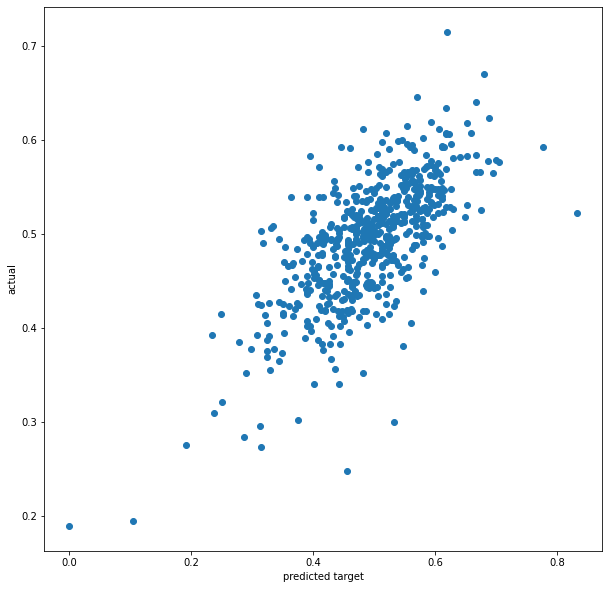

In [305]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlabel('predicted target')
plt.ylabel('actual')
plt.show()

## other basic models 

In [252]:
imputer_mean = impute.SimpleImputer()
X_train_ = imputer_mean.fit_transform(X_train)
X_test_ = imputer_mean.transform(X_test)

In [254]:
#@title linear regression

reg1 = linear_model.LinearRegression()
reg1.fit(X_train_, y_train)
y_pred1 = reg1.predict(X_test_)
print(metrics.r2_score(y_test, y_pred1))

-1.6872669340836102e+19


In [255]:
#@title decision tree
reg2 = tree.DecisionTreeRegressor()
reg2.fit(X_train_, y_train)
y_pred2 = reg2.predict(X_test_)
print(metrics.r2_score(y_test, y_pred2))

-0.13121094463208105
